In [1]:
import pandas as pd
import numpy as np
import bankruptcy as br
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from time import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score 

In [2]:
df = pd.read_csv('Company_Bankruptcy_Prediction.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [3]:
clean_df = br.clean_data(df)

Dropping columns ['Net_Income_Flag'] that have only one value
Dropping 0 row(s) with NAs


Before oversampling, the minor class of the traing set has 169 samples.
After oversampling, the minor class of the traing set has 4604 samples.


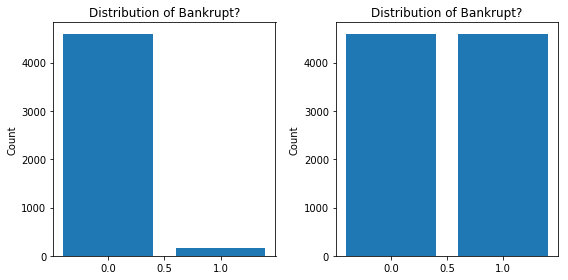

In [4]:
X_train, X_test, y_train, y_test, scalers = br.prepare_model_data(clean_df, 'Bankrupt?', test_size = .3, 
                                                                  scale_x = True, scale_y = False, 
                                                                  oversample = True)

In [5]:
clf = br.xgb(X_train, y_train)

Time: 7.62 seconds


In [6]:
clf

(7.615249872207642,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.5, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=None, n_estimator=5, n_estimators=100,
               n_jobs=1, nthread=None, objective='binary:logistic',
               random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=None, subsample=1, verbosity=1))

### PCA

In [13]:
pca_all = PCA()
X_pca = pca_all.fit_transform(X_scaled)

In [14]:
def scree_plot(pca):
    """
    Creates a scree plot associated with the principal components.
    """
    n_comps = len(pca.explained_variance_ratio_)
    index = np.arange(n_comps)
    values = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    cum_values = np.cumsum(values)
    plt.bar(index, values)
    plt.plot(index, cum_values)
    
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    plt.xlim(-5, 93)

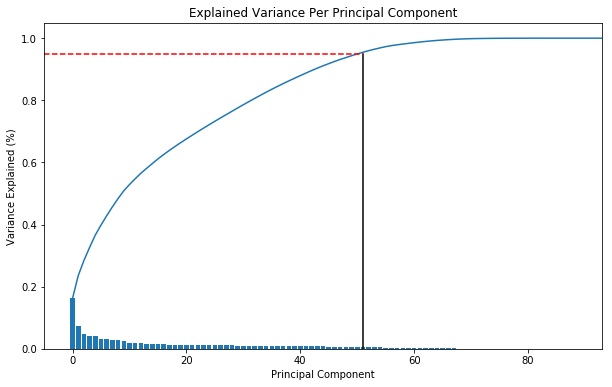

In [15]:
scree_plot(pca_all)
plt.plot([51, 51], [0, 0.95], color='black')
plt.plot([-5, 51], [0.95, 0.95], linestyle='--', color='red');

In [16]:
values = pca_all.explained_variance_ratio_
cum_values = np.cumsum(values)

In [17]:
np.where(cum_values > 0.95)

(array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),)

In [18]:
pca_52 = PCA(52)
X_pca = pca_52.fit_transform(X_scaled)

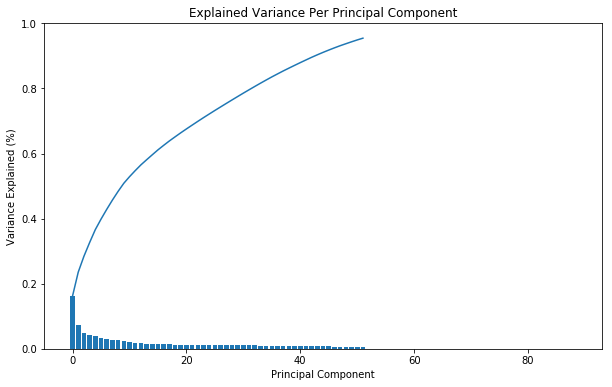

In [19]:
scree_plot(pca_52)

In [20]:
pca_52.explained_variance_ratio_.sum()

0.9546337610230244

In [21]:
X_pca.shape

(13198, 52)

### Train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.25)

In [23]:
# Instantiate a classifier
clf = XGBClassifier(learning_rate=0.05, n_estimator=300, max_depth=5)
    
# Fit the model to the training data
start1 = time() # get start time
clf.fit(X_train, y_train)
end1 = time() # get end time
    
# Make predictions for the train data and the test data
y_pred_train = clf.predict(X_train)
start2 = time() # get start time
y_pred_test = clf.predict(X_test)
end2 = time() # get end time
    
# Evaluate model performance: training time, accuracy, F1 score
results = {}
results['train_time'] = end1 - start1 # training time in second
results['pred_time'] = end2 - start2 # prediction time in second
results['acc_train'] = accuracy_score(y_train, y_pred_train) # accuracy for train set
results['acc_test'] = accuracy_score(y_test, y_pred_test) # accuracy for test set
results['f1_train'] = f1_score(y_train, y_pred_train) # f1 score for train set
results['f1_test'] = f1_score(y_test, y_pred_test) # f1 score for test set

In [24]:
results

{'train_time': 6.662772178649902,
 'pred_time': 0.01717400550842285,
 'acc_train': 0.9698929076581128,
 'acc_test': 0.9478787878787879,
 'f1_train': 0.9706577392674282,
 'f1_test': 0.95}